# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
print(filtered_data['Score'].value_counts())
filtered_data.head(3)


Number of data points in our data (100000, 10)
1    83876
0    16124
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
print(filtered_data['Score'].value_counts())


1    83876
0    16124
Name: Score, dtype: int64


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [15]:


final_pos = final[(final.Score==1)]
final_neg = final[(final.Score==0)]

final_pos = final.sample(frac = 0.3)
final = final_pos.append(final_neg)

final['Score'].value_counts()

1    22064
0    18449
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 40513/40513 [00:11<00:00, 3586.33it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [19]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

count_vect = CountVectorizer(min_df=5) 
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler(with_mean=False)
#scaler.fit(test_vect)  
#train_vect = scaler.transform(train_vect)
#test_vect = scaler.transform(test_vect)
#cv_vect = scaler.transform(cv_vect)


print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1    6615
0    5539
Name: Score, dtype: int64
After vectorizations
(19851, 8378) (19851,)
(8508, 8378) (8508,)
(12154, 8378) (12154,)


In [20]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [21]:
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)
for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

100%|██████████| 10/10 [03:08<00:00, 19.39s/it]


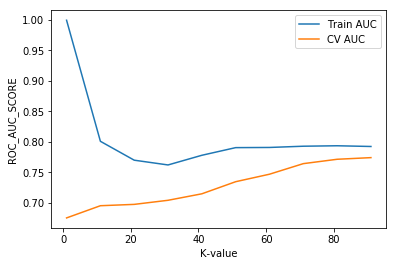

In [22]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.xlabel('K-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
#print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.7701948950730318


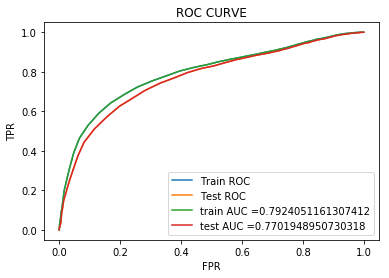

In [25]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='brute')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_bow = auc(test_fpr,test_tpr)
print("test_auc",auc_bow)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_bow = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_bow)

the maximum value of tpr*(1-fpr) 0.5390467511497563 for threshold 0.615
Train confusion matrix
[[7115 1930]
 [3401 7405]]
Test confusion matrix
[[4212 1327]
 [2214 4401]]
Test accuracy :  0.6436564094125391


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [27]:
# Please write all the code with proper documentation
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)

count_vect = TfidfVectorizer(min_df=5)#ngram_range=(1,2), min_df=5,max_features=1000) 

count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)

#print(train_vect.shape)
test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)
print(train_vect.shape)

(18185, 7983)


In [28]:
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)

for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=-1)
    knn.fit(train_vect, y_tr)

    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    #cv_pred = cv_pred[:].max(axis=1)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

100%|██████████| 10/10 [04:26<00:00, 26.98s/it]


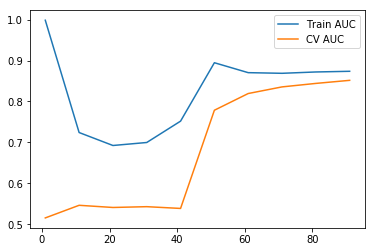

Best K-Value 91


In [29]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.847763353667609


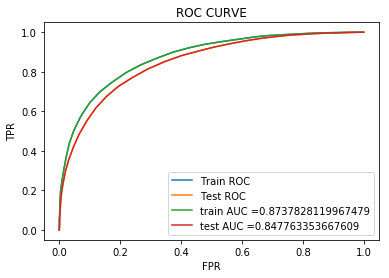

In [30]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='brute')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_tfid = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_tfid = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid)

the maximum value of tpr*(1-fpr) 0.6213020070406121 for threshold 0.582
Train confusion matrix
[[6447 1816]
 [2021 7901]]
Test confusion matrix
[[4643 1467]
 [1664 5596]]
Test accuracy :  0.6954375467464473


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [32]:
def w2v_fit(preprocessed_reviews):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())

    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        print(w2v_model.wv.most_similar('great'))
        print('='*50)
        print(w2v_model.wv.most_similar('worst'))

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    return w2v_model

In [33]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_transform(w2v_model,list_of_sentence):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    #w2v_model = word2Vec(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    for sent in tqdm(list_of_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        word_len = 0;
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                word_len += 1
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vec = sent_vec.tolist()
        sent_vec.append(word_len) 
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

In [34]:

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)

list_of_sentance=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())

w2v_model=w2v_fit(X_tr)
#w2v_words = list(w2v_model.wv.vocab)

test_vect = avg_w2v_transform(w2v_model,X_test)
cv_vect = avg_w2v_transform(w2v_model,X_cv)
train_vect = avg_w2v_transform(w2v_model,X_tr)

  1%|          | 97/13370 [00:00<00:13, 958.59it/s]

[('good', 0.8088615536689758), ('wonderful', 0.7763307094573975), ('awesome', 0.7579760551452637), ('amazing', 0.7490124702453613), ('excellent', 0.7411847114562988), ('perfect', 0.7396558523178101), ('decent', 0.6937140226364136), ('well', 0.6838428974151611), ('delicious', 0.6804043650627136), ('nice', 0.6703143119812012)]
[('ever', 0.8460726141929626), ('best', 0.7738516330718994), ('nastiest', 0.7470898628234863), ('eaten', 0.7273821234703064), ('toughest', 0.726611852645874), ('smoothest', 0.7164272665977478), ('superior', 0.703944206237793), ('american', 0.7011862993240356), ('tried', 0.7002617716789246), ('far', 0.6950114369392395)]


100%|██████████| 18185/18185 [00:16<00:00, 1122.63it/s]


In [35]:
from sklearn import preprocessing


test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)

In [36]:
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)
for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

100%|██████████| 10/10 [01:44<00:00, 10.82s/it]


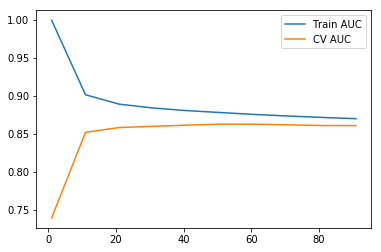

Best K-Value 51


In [37]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.861814012356442


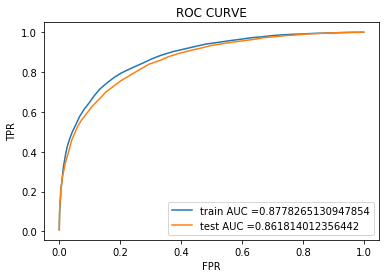

In [38]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='brute')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_w2v = auc(test_fpr,test_tpr)
print("test_auc",auc_w2v)
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))


accuracy_w2v = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_w2v)


the maximum value of tpr*(1-fpr) 0.6336730070306479 for threshold 0.549
Train confusion matrix
[[6828 1498]
 [2241 7618]]
Test confusion matrix
[[4838 1227]
 [1779 5526]]
Test accuracy :  0.7777860882572925


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [40]:
def tf_idf_transform(model,w_model,list_of_sentence):
    # TF-IDF weighted Word2Vec
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    #print(list_of_sentence)
    for sent in tqdm(list_of_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        #print(sent)
        #print("+++++++")
        for word in sent.split():
            #print(word)# for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
                #print(sent_vec)
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [41]:
# Please write all the code with proper documentation
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


model = TfidfVectorizer()
model.fit(X_tr)
w2v_model = w2v_fit(X_tr)

#count_vect = CountVectorizer(ngram_range=(1,2)) 
tfidf_feat = model.get_feature_names() # tfidf words/col-names
#print(tfidf_feat)
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
#print(w2v_words)
##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = tf_idf_transform(model,w2v_model,X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = tf_idf_transform(model,w2v_model,X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = tf_idf_transform(model,w2v_model,X_tr)


  0%|          | 33/13370 [00:00<01:23, 159.38it/s]

[('awesome', 0.7998536825180054), ('good', 0.7981560826301575), ('wonderful', 0.7602270245552063), ('excellent', 0.754985511302948), ('fantastic', 0.73101407289505), ('perfect', 0.7148163318634033), ('amazing', 0.6979557275772095), ('delicious', 0.6664267778396606), ('decent', 0.6476465463638306), ('nice', 0.6433314085006714)]
[('ever', 0.8407456278800964), ('best', 0.8003098964691162), ('hottest', 0.776080310344696), ('superior', 0.732591986656189), ('smoothest', 0.7137599587440491), ('experienced', 0.7077652215957642), ('world', 0.704701840877533), ('far', 0.7000476717948914), ('remember', 0.6902618408203125), ('nastiest', 0.6887807846069336)]


100%|██████████| 18185/18185 [02:09<00:00, 140.44it/s]


In [42]:
from sklearn import preprocessing


test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)


In [43]:
train_auc = []
cv_auc = []
K_values = list(range(1,110,10))
#K_values = [1].append(K_values)
for i in K_values:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_vect, y_tr)

    # predict the response on the crossvalidation train
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

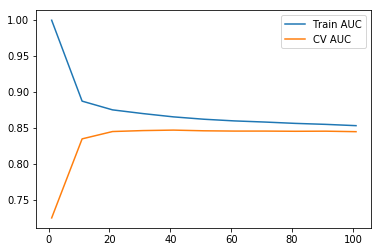

Best K-Value 41


In [44]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.847806226522732


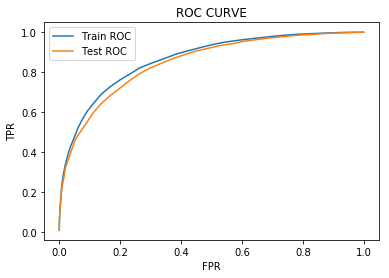

In [45]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='brute')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_tfid_w2v = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_w2v)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_tfid_w2v = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_w2v)


the maximum value of tpr*(1-fpr) 0.6099928221703884 for threshold 0.561
Train confusion matrix
[[6570 1649]
 [2361 7605]]
Test confusion matrix
[[4661 1404]
 [1760 5545]]
Test accuracy :  0.7670157068062827


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [47]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

count_vect = CountVectorizer(min_df=5,max_features=100)#min_df=5, max_features=1000) 
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)

train_vect_dense = train_vect.todense()
cv_vect_dense = cv_vect.todense()
test_vect_dense = test_vect.todense()

print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

1    6615
0    5539
Name: Score, dtype: int64
After vectorizations
(19851, 100) (19851,)
(8508, 100) (8508,)
(12154, 100) (12154,)


In [48]:
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)
for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs = -1)
    knn.fit(train_vect_dense, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect_dense)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect_dense)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

100%|██████████| 10/10 [02:35<00:00, 16.14s/it]


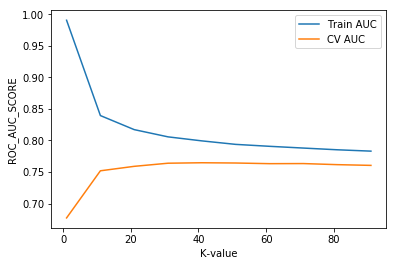

Best K-Value 41


In [49]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.xlabel('K-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.7692477869766189


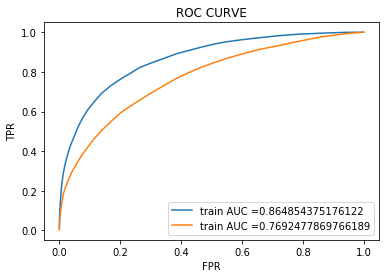

In [50]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='kd_tree')
best_knn.fit(train_vect_dense, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect_dense)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect_dense)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
train_fpr, train_tpr, train_thresh = roc_curve(y_tr, train_pred)

auc_bow_k = auc(test_fpr,test_tpr)
print("test_auc",auc_bow_k)

plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_bow_k = best_knn.score(test_vect_dense, y_test)
print("Test accuracy : ",accuracy_bow_k)


the maximum value of tpr*(1-fpr) 0.6099928221703884 for threshold 0.561
Train confusion matrix
[[7709 1339]
 [4573 6230]]
Test confusion matrix
[[4598  941]
 [2978 3637]]
Test accuracy :  0.6922823761724535


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [52]:
# Please write all the code with proper documentation
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)

count_vect = TfidfVectorizer(min_df=5,max_features=500)#ngram_range=(1,2), min_df=5,max_features=1000) 

count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)


train_vect_dense = train_vect.todense()
cv_vect_dense = cv_vect.todense()
test_vect_dense = test_vect.todense()

#print(train_vect.shape)
test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)
print(train_vect.shape)

(18185, 500)


In [53]:
from scipy.sparse import csr_matrix 
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)

for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)
    knn.fit(train_vect_dense, y_tr)

    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect_dense)
    #cv_pred = cv_pred[:].max(axis=1)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect_dense)
    train_pred = train_pred[:,1]
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

100%|██████████| 10/10 [12:15<00:00, 75.54s/it]


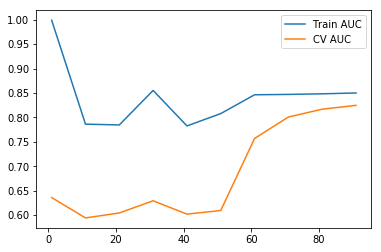

Best K-Value 91


In [54]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.8289482460293632


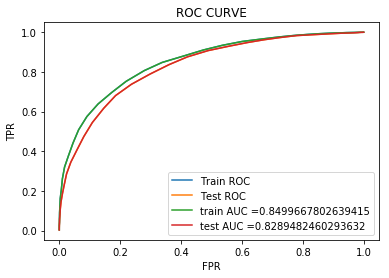

In [55]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='kd_tree')
best_knn.fit(train_vect_dense, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect_dense)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect_dense)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_tfid_k = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_k)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_tfid_k = best_knn.score(test_vect_dense, y_test)
print("Test accuracy : ",accuracy_tfid_k)


the maximum value of tpr*(1-fpr) 0.5871500331283056 for threshold 0.626
Train confusion matrix
[[6471 1819]
 [2452 7443]]
Test confusion matrix
[[4647 1442]
 [1912 5369]]
Test accuracy :  0.600074794315632


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [57]:
def w2v_fit(preprocessed_reviews):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())

    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        print(w2v_model.wv.most_similar('great'))
        print('='*50)
        print(w2v_model.wv.most_similar('worst'))

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    return w2v_model

In [58]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_transform(w2v_model,list_of_sentence):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    #w2v_model = word2Vec(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    for sent in tqdm(list_of_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        word_len = 0;
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                word_len += 1
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vec = sent_vec.tolist()
        sent_vec.append(word_len) 
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

In [59]:

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)

list_of_sentance=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())

w2v_model=w2v_fit(X_tr)
#w2v_words = list(w2v_model.wv.vocab)

test_vect = avg_w2v_transform(w2v_model,X_test)
cv_vect = avg_w2v_transform(w2v_model,X_cv)
train_vect = avg_w2v_transform(w2v_model,X_tr)

  1%|          | 102/13370 [00:00<00:13, 1014.06it/s]

[('excellent', 0.8033679723739624), ('awesome', 0.7895879745483398), ('good', 0.784648597240448), ('wonderful', 0.7775641679763794), ('perfect', 0.7547731399536133), ('amazing', 0.7472608089447021), ('nice', 0.6775152683258057), ('fantastic', 0.6692057847976685), ('quick', 0.663090169429779), ('delicious', 0.6627322435379028)]
[('ever', 0.8510439991950989), ('nastiest', 0.8210798501968384), ('best', 0.7804007530212402), ('far', 0.7680622935295105), ('hottest', 0.747269332408905), ('tried', 0.7431512475013733), ('eaten', 0.727228045463562), ('world', 0.7026196718215942), ('fluff', 0.6960117816925049), ('lover', 0.6857409477233887)]


100%|██████████| 18185/18185 [00:16<00:00, 1092.86it/s]


In [60]:
from sklearn import preprocessing


test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)

In [61]:
train_auc = []
cv_auc = []
K_values = list(range(1,100,10))
#K_values = [1].append(K_values)
for i in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

100%|██████████| 10/10 [04:19<00:00, 28.45s/it]


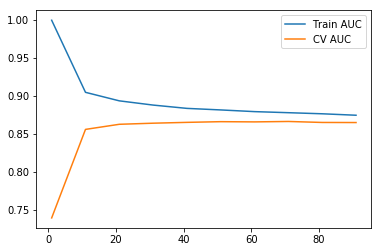

Best K-Value 71


In [62]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.8658140958687908


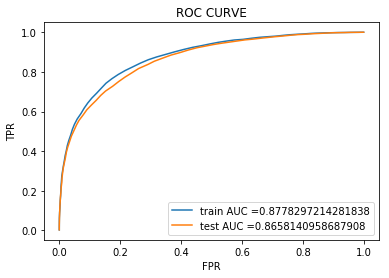

In [63]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='kd_tree')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_w2v_k = auc(test_fpr,test_tpr)
print("test_auc",auc_w2v_k)
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_w2v_k = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_w2v_k)


the maximum value of tpr*(1-fpr) 0.634502607813893 for threshold 0.535
Train confusion matrix
[[6650 1597]
 [2118 7820]]
Test confusion matrix
[[4754 1311]
 [1651 5654]]
Test accuracy :  0.7817501869857891


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [65]:
# Please write all the code with proper documentation
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


model = TfidfVectorizer()
model.fit(X_tr)
w2v_model = w2v_fit(X_tr)

#count_vect = CountVectorizer(ngram_range=(1,2)) 
tfidf_feat = model.get_feature_names() # tfidf words/col-names
#print(tfidf_feat)
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
#print(w2v_words)
##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = tf_idf_transform(model,w2v_model,X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = tf_idf_transform(model,w2v_model,X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = tf_idf_transform(model,w2v_model,X_tr)


  0%|          | 17/13370 [00:00<01:19, 167.62it/s]

[('good', 0.8192682266235352), ('excellent', 0.7996620535850525), ('wonderful', 0.7894243001937866), ('awesome', 0.782963216304779), ('perfect', 0.7347865700721741), ('amazing', 0.6983234882354736), ('decent', 0.6900320649147034), ('quick', 0.6896303296089172), ('especially', 0.68128502368927), ('well', 0.6744953393936157)]
[('ever', 0.7872928380966187), ('best', 0.7799702882766724), ('disliked', 0.7574388980865479), ('nastiest', 0.7386596202850342), ('hottest', 0.7321525812149048), ('horrible', 0.7024319171905518), ('world', 0.6821147203445435), ('smoothest', 0.6815444231033325), ('experienced', 0.6774165630340576), ('eaten', 0.6764891147613525)]


100%|██████████| 18185/18185 [02:13<00:00, 136.00it/s]


In [66]:
from sklearn import preprocessing


test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)


In [67]:
print(test_vect[0])

[ 0.11087772 -0.23936488 -0.25637915  0.11381015 -0.06732539 -0.03469526
 -0.00758352 -0.1057861   0.02491225 -0.05842095  0.0240777   0.00923636
 -0.02959191 -0.26146931  0.16085796 -0.16457531  0.11780185 -0.04816162
 -0.17065313 -0.10104775  0.40738853  0.00745566  0.19023979 -0.0348534
 -0.12079089 -0.02708758 -0.12987058  0.17917065 -0.04314873 -0.04638817
 -0.0810758  -0.23763364 -0.18652523 -0.0410039   0.07728023 -0.01137522
  0.0196215   0.29566153  0.07537057  0.09995291 -0.11259662 -0.15813216
  0.22013837 -0.03311653 -0.10149643  0.07846037 -0.11993394  0.11342481
  0.19936003  0.02822038]


In [68]:
train_auc = []
cv_auc = []
K_values = list(range(1,110,10))
#K_values = [1].append(K_values)
for i in K_values:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_vect, y_tr)

    # predict the response on the crossvalidation train
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = knn.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = knn.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

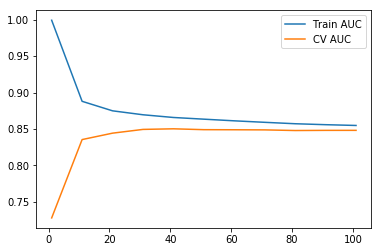

Best K-Value 41


In [69]:
plt.plot(K_values, train_auc, label='Train AUC')
plt.plot(K_values, cv_auc, label='CV AUC')
plt.legend()
plt.show()  
print("Best K-Value", K_values[cv_auc.index(max(cv_auc))])

test_auc 0.8517108463920127


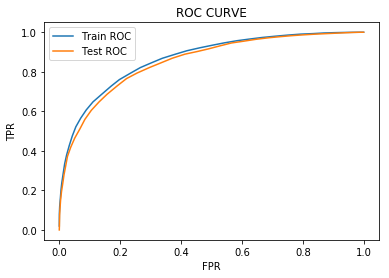

In [70]:
best_knn = KNeighborsClassifier(n_neighbors=K_values[cv_auc.index(max(cv_auc))],algorithm='kd_tree')
best_knn.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_knn.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_knn.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)

auc_tfid_w2v_k = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_w2v_k)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_pred, best_t)))

accuracy_tfid_w2v_k = best_knn.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_w2v_k)


the maximum value of tpr*(1-fpr) 0.6102558759463205 for threshold 0.561
Train confusion matrix
[[6670 1640]
 [2367 7508]]
Test confusion matrix
[[4725 1340]
 [1712 5593]]
Test accuracy :  0.7680628272251309


# [6] Conclusions

In [73]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

## Prettytable reference: http://zetcode.com/python/prettytable/
x = PrettyTable(["Model", "Vectoriser", "Hyperparameter", "AUC"])

x.add_row(["KNN","BOW", 91 ,auc_bow])
x.add_row(["KNN","TFIDF",  91,auc_tfid])
x.add_row(["KNN","AVGW2V", 41,auc_w2v])
x.add_row(["KNN","TFIDF W2V",51, auc_tfid_w2v])

x.add_row(["KNN-kd","BOW", 41,auc_bow_k])
x.add_row(["KNN-kd","TFIDF",91 ,auc_tfid_k])
x.add_row(["KNN-kd","AVGW2V", 71,auc_w2v_k])
x.add_row(["KNN-kd","TFIDF W2V",41 ,auc_tfid_w2v_k])
print(x.get_string())

+--------+------------+----------------+--------------------+
| Model  | Vectoriser | Hyperparameter |        AUC         |
+--------+------------+----------------+--------------------+
|  KNN   |    BOW     |       91       | 0.7701948950730318 |
|  KNN   |   TFIDF    |       91       | 0.847763353667609  |
|  KNN   |   AVGW2V   |       41       | 0.861814012356442  |
|  KNN   | TFIDF W2V  |       51       | 0.847806226522732  |
| KNN-kd |    BOW     |       41       | 0.7692477869766189 |
| KNN-kd |   TFIDF    |       91       | 0.8289482460293632 |
| KNN-kd |   AVGW2V   |       71       | 0.8658140958687908 |
| KNN-kd | TFIDF W2V  |       41       | 0.8517108463920127 |
+--------+------------+----------------+--------------------+


Summary:

Amazon food review classification was done with KNN classifier with BOW, TFIDF, AVGW2V and TFIDFW2V vectorizers.

1. Text preprocessing was done on the reviews column of the dataset.
2. For KNN-kd model, incase of BOW and TFIDF vectorizers the input vectors were turned to dense and then model was run.
2. The AUC of the model in different cases were tabulated. 
   i. It is found that the model AUC value of TFIDF, AVGW2V and TFIDFW2V are better than its corresponding BOW model.
